## [Link to Github](https://github.com/suomynona25/DSA4262)

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import shap

# from lime import lime_text
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import OneHotEncoder


In [11]:
cwd = os.getcwd()
print(f'Current working directory is {cwd}')

# Import data
test_df = pd.read_csv('./data/dreaddit/dreaddit-test.csv')
train_df = pd.read_csv('./data/dreaddit/dreaddit-train.csv')
# combined_df = pd.concat([test_df, train_df], axis=0).reset_index(drop=True)

print(f"Training data shape: {train_df.shape}")
print(f"Testing data shape: {test_df.shape}")
# print(f"Testing data shape: {combined_df.shape}")

train_df.head(3)

Current working directory is c:\Users\fengm\Documents\DSA4262
Training data shape: (2838, 116)
Testing data shape: (715, 116)


,subreddit,post_id,sentence_range,text,id,label,confidence,social_timestamp,social_karma,syntax_ari,...,lex_dal_min_pleasantness,lex_dal_min_activation,lex_dal_min_imagery,lex_dal_avg_activation,lex_dal_avg_imagery,lex_dal_avg_pleasantness,social_upvote_ratio,social_num_comments,syntax_fk_grade,sentiment
0,ptsd,8601tu,"(15, 20)","He said he had not felt that way before, sugge...",33181,1,0.8,1521614353,5,1.806818,...,1.000,1.1250,1.0,1.77000,1.52211,1.89556,0.86,1,3.253573,-0.002742
1,assistance,8lbrx9,"(0, 5)","Hey there r/assistance, Not sure if this is th...",2606,0,1.0,1527009817,4,9.429737,...,1.125,1.0000,1.0,1.69586,1.62045,1.88919,0.65,2,8.828316,0.292857
2,ptsd,9ch1zh,"(15, 20)",My mom then hit me with the newspaper and it s...,38816,1,0.8,1535935605,2,7.769821,...,1.000,1.1429,1.0,1.83088,1.58108,1.85828,0.67,0,7.841667,0.011894


## Data preprocessing

In [12]:
train_df.info(verbose=True, show_counts=True)
# test_df.info(verbose=True, show_counts=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2838 entries, 0 to 2837
Data columns (total 116 columns):
 #    Column                    Non-Null Count  Dtype  
---   ------                    --------------  -----  
 0    subreddit                 2838 non-null   object 
 1    post_id                   2838 non-null   object 
 2    sentence_range            2838 non-null   object 
 3    text                      2838 non-null   object 
 4    id                        2838 non-null   int64  
 5    label                     2838 non-null   int64  
 6    confidence                2838 non-null   float64
 7    social_timestamp          2838 non-null   int64  
 8    social_karma              2838 non-null   int64  
 9    syntax_ari                2838 non-null   float64
 10   lex_liwc_WC               2838 non-null   int64  
 11   lex_liwc_Analytic         2838 non-null   float64
 12   lex_liwc_Clout            2838 non-null   float64
 13   lex_liwc_Authentic        2838 non-null   floa

There are no nulls in the dataset

In [13]:
#Check if id is unique
print(f'Unique id: {len(train_df['id'].unique())}')

Unique id: 2838


ID is unique

### Null handling
- No nulls

### Explanation of columns
- sentence_range: The location of the chunk of 5 sentences within the comment
- id: ID given to the chunk
- confidence: The ratio of annotators who agreed on the label
- syntax_ari: Automated readability index, basically how complex the english is
- lex_liwc-: Scores for each category of LIWC, basically an algorithm that analyses the mood and emotions of text
- syntax_fk_grade: Another english complexity score
- lex_dal-: Another mood analysis scorer

### Column changes
- 0: One hot encoding
- 1: drop since we just need each comment's unique ID, not the post it belongs to
- 2: Normalise into int sentence_start and sentence_end columns
- 3: drop (for classical neural network model training)
- 4: Turn into index
- 6: Drop  (we assume that all the labels are correct)
- 7: Drop (chronological feature has no meaning in model)

### Data transformation function

In [14]:
def clean_data(df):    
    #OHE column 0
    encoder = OneHotEncoder(drop='first', sparse_output=False)
    encoded = encoder.fit_transform(df[['subreddit']])
    encoded_cols = pd.DataFrame(encoded, columns=encoder.get_feature_names_out())
    cleaned_df = pd.concat([df.drop('subreddit', axis=1), encoded_cols], axis=1)

    #Drop cols 1,3,6,7
    cleaned_df = cleaned_df.drop(['post_id', 'text', 'confidence', 'social_timestamp'], axis= 1)

    #Split col 2 into two cols
    cleaned_df[['sentence_start','sentence_end']] = cleaned_df['sentence_range'].str.strip('()[]').str.split(', ', expand=True)
    cleaned_df = cleaned_df.drop('sentence_range', axis=1)

    #Turn col 4 into index
    cleaned_df = cleaned_df.set_index('id')
    return cleaned_df

## Exploratory data analysis

### Target distribution


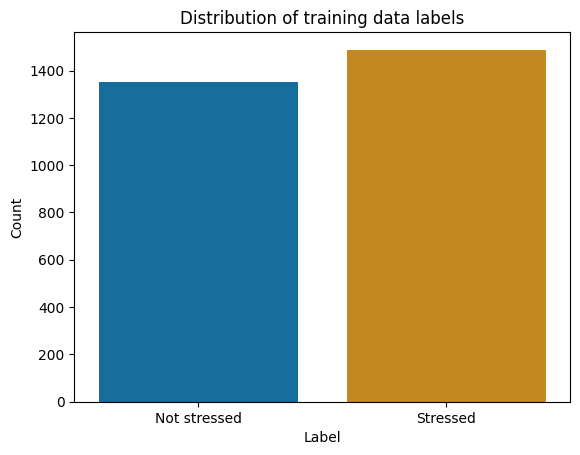

In [15]:
ax = sns.countplot(data=train_df, x='label', hue='label', palette='colorblind', legend=False)
ax.set_xticks([0, 1])
ax.set_xticklabels(['Not stressed', 'Stressed'])
plt.title('Distribution of training data labels')
plt.ylabel("Count")
plt.xlabel('Label')

plt.show()

### What is the distribution of the labels' confidence?

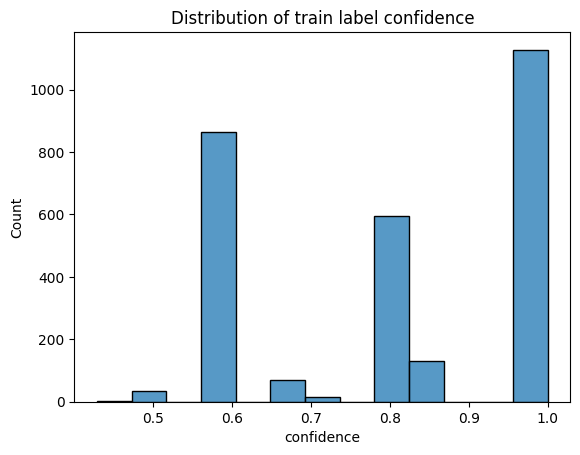

In [16]:
sns.histplot(data = train_df, x='confidence')
plt.title('Distribution of train label confidence')
plt.show()

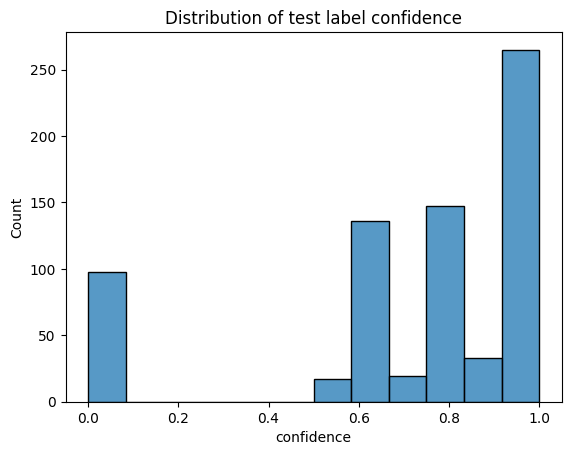

In [17]:
sns.histplot(data = test_df, x='confidence')
plt.title('Distribution of test label confidence')
plt.show()

Since most of the labels have >= 0.8 confidence, we will only keep labels past this treshold

### Correlation matrix

We will have to use the transformed dataset for correlation matrix to work

In [18]:
cleaned_train_df = clean_data(train_df)
cleaned_test_df = clean_data(test_df)
cleaned_train_df.head()

,label,social_karma,syntax_ari,lex_liwc_WC,lex_liwc_Analytic,lex_liwc_Clout,lex_liwc_Authentic,lex_liwc_Tone,lex_liwc_WPS,lex_liwc_Sixltr,...,subreddit_assistance,subreddit_domesticviolence,subreddit_food_pantry,subreddit_homeless,subreddit_ptsd,subreddit_relationships,subreddit_stress,subreddit_survivorsofabuse,sentence_start,sentence_end
id,,,,,,,,,,,,,,,,,,,,,
33181,1,5,1.806818,116,72.64,15.04,89.26,1.00,29.00,12.93,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,15,20
2606,0,4,9.429737,109,79.08,76.85,56.75,98.18,27.25,21.10,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,5
38816,1,2,7.769821,167,33.80,76.38,86.24,25.77,33.40,17.37,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,15,20
239,1,0,2.667798,273,2.98,15.25,95.42,79.26,54.60,8.06,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,5,10
1421,1,24,7.554238,89,32.22,28.71,84.01,1.00,17.80,31.46,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,5


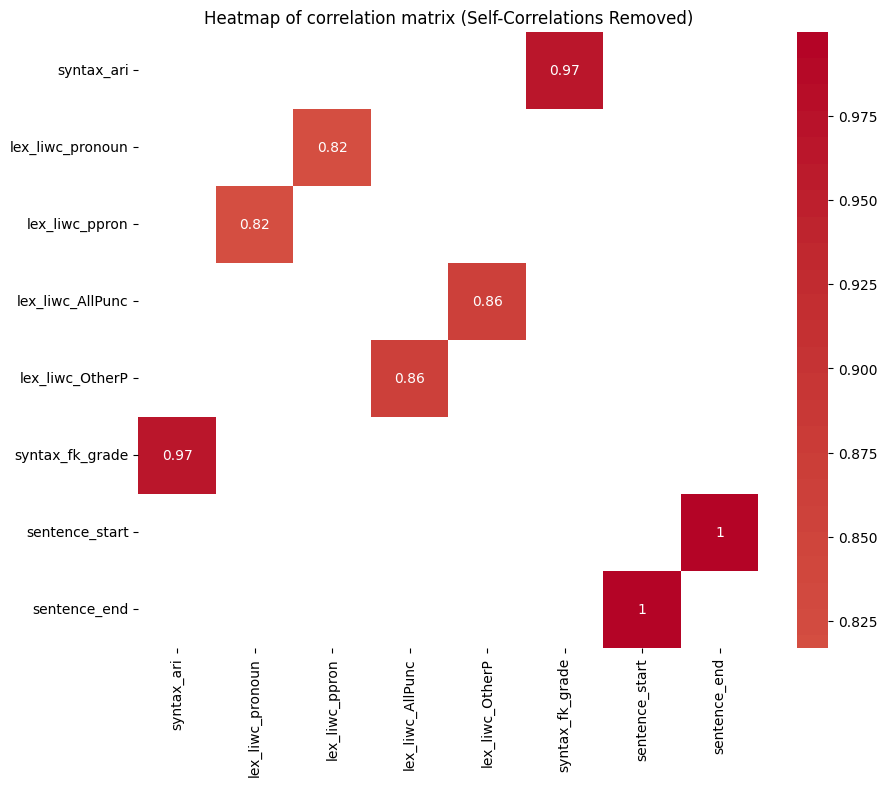

In [19]:
corr_mat = cleaned_train_df.corr()

# replace the self-correlations with NaN (blank) so they don't trick our filter
np.fill_diagonal(corr_mat.values, np.nan)

# Filter the matrix for strong correlations
filtered_corr = corr_mat[corr_mat.abs() >= 0.8]

# Drop the empty rows and columns
filtered_corr = filtered_corr.dropna(axis=0, how='all').dropna(axis=1, how='all')

plt.figure(figsize=(10, 8))
sns.heatmap(filtered_corr, annot=True, cmap='coolwarm', center=0, cbar=True)
plt.title("Heatmap of correlation matrix (Self-Correlations Removed)")
plt.show()

### Subreddit analysis

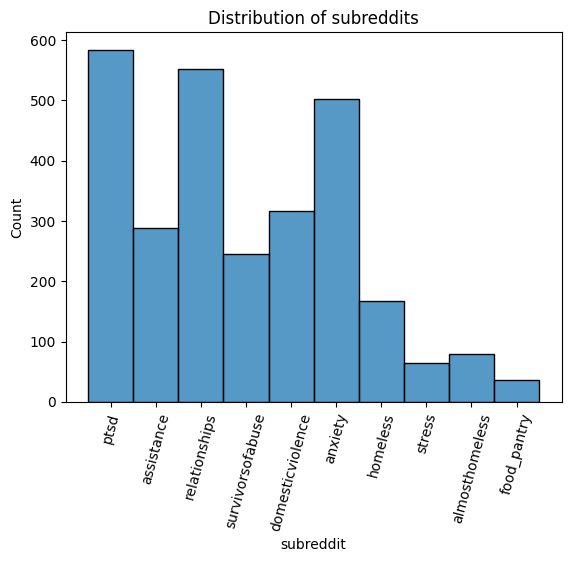

In [20]:
sns.histplot(data = train_df, x='subreddit')
plt.xticks(rotation=75)
plt.title('Distribution of subreddits')
plt.show()

## Model

### Model Choice

Since numeric data derived from the text via other linguistic analysis tools are available, we can first try training a classifier model using just numeric data, without using the text data.

For the purpose of classification, RandomForest might be a suitable model since it is an ensemble model comprising of many decision trees, which are especially great for classification tasks. Furthermore, decision trees are highly interpretable which places it at an advantage as a clinical sense-making tool. It is easier to trust a model whose decisions can be understood by humans over a model that is a black box, especially in the healthcare context.

In [21]:
rf_model = RandomForestClassifier(random_state=67)

#Split dataset into features and targets
X_train = cleaned_train_df.copy().drop('label', axis=1)
y_train = cleaned_train_df[['label']]

X_test = cleaned_test_df.copy().drop('label', axis=1)
y_test = cleaned_test_df[['label']]


### Hyperparameter tuning and model fitting

We will be using GridsearchCV method for finding the optimal hyperparameters

In [22]:
# Define hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300],         # How many "board members" (trees) to vote
    'max_depth': [None, 10, 20],             # How deep/complex their decision process can be
    'min_samples_split': [2, 5, 10],         # Minimum data points needed to make a new rule
    'class_weight': ['balanced', None]       # 'balanced' helps if we have unequal amounts of stressed vs non-stressed data
}

# Initialise grid search obj
grid_search = GridSearchCV(estimator=rf_model, 
                           param_grid=param_grid, 
                           cv=5, 
                           scoring='f1', 
                           n_jobs=-1, 
                           verbose=2)

# Fit grid search
grid_search.fit(X_train, y_train)

best_rf_model = grid_search.best_estimator_
print(grid_search.best_params_)


Fitting 5 folds for each of 54 candidates, totalling 270 fits


c:\Users\fengm\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\base.py:1336: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


{'class_weight': None, 'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}


### Prediction
Now we can apply the model on the test dataset

In [23]:
y_pred = best_rf_model.predict(X_test)

### Model evaluation


Test F1-Score: 0.7723

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.71      0.74       346
           1       0.75      0.80      0.77       369

    accuracy                           0.76       715
   macro avg       0.76      0.76      0.76       715
weighted avg       0.76      0.76      0.76       715



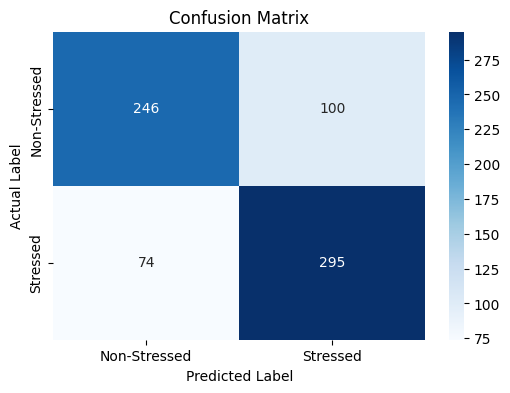

In [24]:
# Calculate the F1 Score
f1 = f1_score(y_test, y_pred)
print(f"Test F1-Score: {f1:.4f}\n")

# Print the full classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Plot the Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Stressed', 'Stressed'], yticklabels=['Non-Stressed', 'Stressed'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.show()

The Random Forest baseline model achieved an overall Test F1-Score of 0.772, which is a decent score. From the classification report, for the "stressed" class (label 1), the model exhibits a higher recall of 0.80 but a slightly lower precision of 0.75. This indicates that the model leans towards being overly sensitive, so it successfully captures 80% of all truly stressed posts but occasionally misclassifies normal posts as stressed. In a mental health or triage context, this behavior is generally preferred, as missing a genuine distress signal (false negative) carries a much higher human risk than misflagging a benign post for human review. For the "non-stressed" class (label 0), the model is more precise (0.77) but has less recall (0.71), further confirming its cautious behaviour.

C:\Users\fengm\AppData\Local\Temp\ipykernel_8708\3996915164.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=sub_perf_df, x='Subreddit', y='F1_Score', palette='mako')


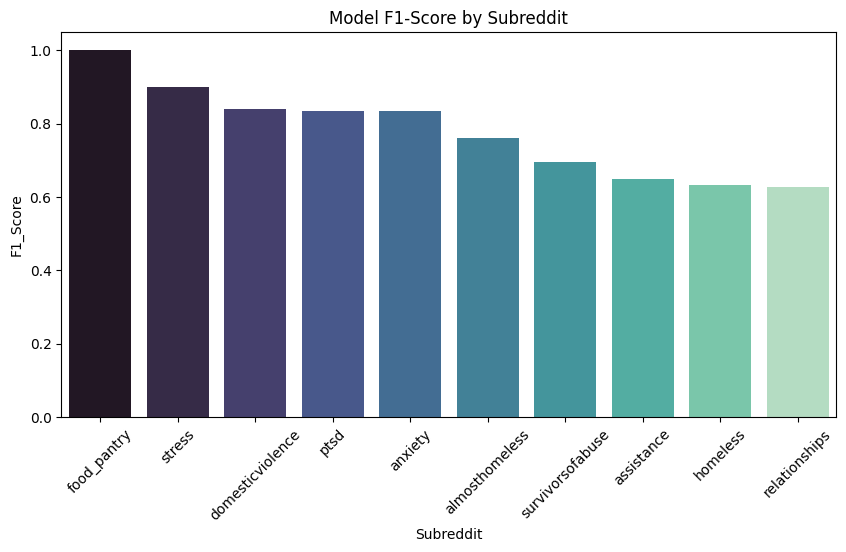

In [25]:
# Create a copy of the test dataframe and add our predictions
analysis_df = test_df.copy()
analysis_df['prediction'] = y_pred

# Calculate F1-score per subreddit
subreddits = analysis_df['subreddit'].unique()
f1_scores = []

for sub in subreddits:
    sub_data = analysis_df[analysis_df['subreddit'] == sub]
    score = f1_score(sub_data['label'], sub_data['prediction'])
    f1_scores.append({'Subreddit': sub, 'F1_Score': score})

sub_perf_df = pd.DataFrame(f1_scores).sort_values(by='F1_Score', ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(data=sub_perf_df, x='Subreddit', y='F1_Score', palette='mako')
plt.title("Model F1-Score by Subreddit")
plt.xticks(rotation=45)
plt.show()

The "food_pantry" subreddit had the highest effectiveness of stress classification when the model was used. This is unsurprising since the subreddit is a place for users to appeal for food donations, which is where language signalling stress will be common.

### Error Analysis

In [26]:
# Find FPs
false_positives = analysis_df[(analysis_df['label'] == 0) & (analysis_df['prediction'] == 1)]

# Find FNs
false_negatives = analysis_df[(analysis_df['label'] == 1) & (analysis_df['prediction'] == 0)]

print("Example of a FALSE POSITIVE (Model thought it was stressed, but it wasn't):")
print(false_positives['text'].iloc[0])
print("\n")

print("Example of a FALSE NEGATIVE (Model thought it was fine, but it was actually stressed):")
print(false_negatives['text'].iloc[0])

Example of a FALSE POSITIVE (Model thought it was stressed, but it wasn't):
If I go to an interview for example, I'll know that I'm a good candidate, I'll know that if I don't get it there will always be other opportunities and it's no big deal. Yet I still get nervous because it's something that I want, I want that employer to like me. If I go to an interview with no expectations at all, not even wanting the job (I've done this a few times for practice interviewing), it'll turn out great. What are your thoughts on this? Edit: FYI I'm talking mostly about social anxiety, though it has happened that I get anxiety in the most random places like just going upstairs in a building.


Example of a FALSE NEGATIVE (Model thought it was fine, but it was actually stressed):
We'd be saving so much money with this new housr...its such an expensive city.... I did some googling in their language and found that it was illegal for them to do that. I was excited like oh ok if it happens ill call the po

An analysis of the model's failure modes reveals clear limitations in using Random Forest for classifying stress on text excerpts. In the false positive example, the model likely predicted stress because the writer mentioned words like "anxiety" which is a clinical term associated with stress. However, the writer was actually framing the conversation in a philosophical manner which the model failed to grasp.

The false negative example began with neutral words like "saving", "exciting", which likely diluted the stress score. However towards the end the writer displayed obvious signs of stress ("i wanna die," "helpless and scared," "ruined my life"). These are phrases that are supposed to trigger a high stress score. What could have happened here is that the keyword-based nature of the model could have missed out on crucial phrases that signal stress. Since the dataset is based on scores given by other lexical analysis tools, if those tools are unable to pick up the negative sentiment in this excerpt, this Random Forest model will likely also be unable to do so. If a directional model such as BERT was used and the text itself was used for training, perhaps such errors could be reduced.

### Model Interpretability

C:\Users\fengm\AppData\Local\Temp\ipykernel_8708\2776896452.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_features, x='Importance', y='Cols', palette='Reds_r')


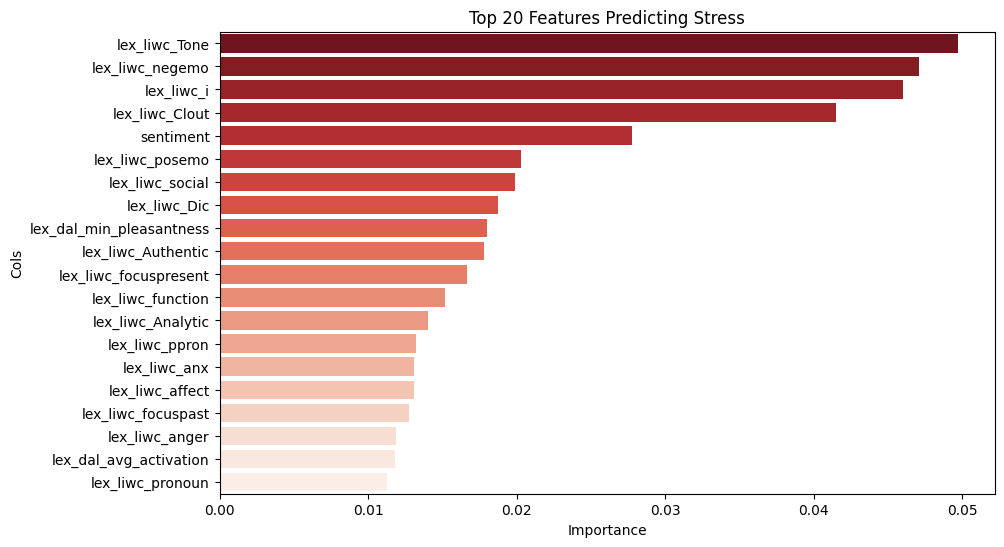

In [27]:
# Get importance scores
importances = best_rf_model.feature_importances_

# Create df to view the top features
feature_df = pd.DataFrame({'Cols': X_test.columns, 'Importance': importances})
top_features = feature_df.sort_values(by='Importance', ascending=False).head(20)

plt.figure(figsize=(10, 6))
sns.barplot(data=top_features, x='Importance', y='Cols', palette='Reds_r')
plt.title("Top 20 Features Predicting Stress")
plt.show()

SHAP shape: (119, 2)
Data shape: (200, 119)


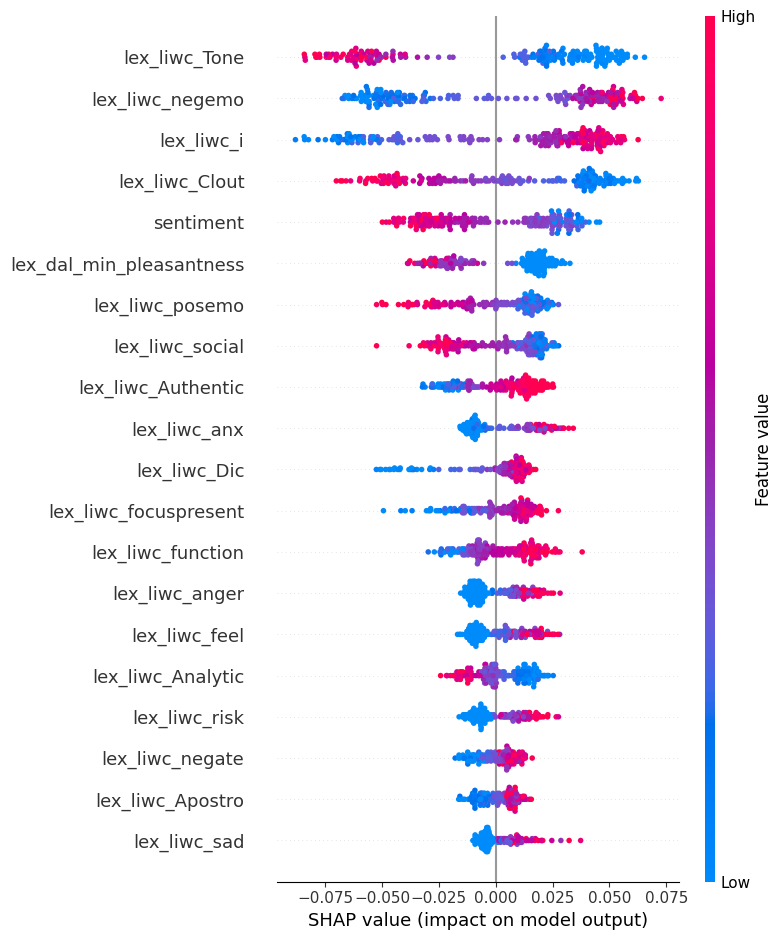

In [28]:
# Initialize SHAP for random forest using subset of data to keep it fast
X_test_sample = X_test.iloc[:200,:]
explainer = shap.TreeExplainer(best_rf_model)

# Calculate SHAP values
shap_values = explainer.shap_values(X_test_sample)


if isinstance(shap_values, list):
    shap_values_stressed = shap_values[1]
else:
    shap_values_stressed = shap_values[:, :, 1]

print(f"SHAP shape: {shap_values[1].shape}")
print(f"Data shape: {X_test_sample.shape}")

shap.summary_plot(shap_values_stressed, X_test_sample)

`lex_liwc_Tone` is indisputedly the most important feature. This suggests that the overall emotional tone of the post is the strongest indicator of stress.

This is followed by `lex_liwc_i` which scores the frequency of first-person pronouns (I, me, my) usage. This indicates that personal pronouns is a classic marker of personal distress in linguistic analysis.

`lex_liwc_negemo`: Negative emotion words are highly predictive, which makes sense for stress detection.


## Risks and ethics discussion

While the Random Forest classifier demonstrates decent performance in its task of classifying whether a text excerpt indicates stress experienced by the writer, its deployment as a tool for detecting stress in a larger scale comes with limitations.

### Risks
#### Internet slangs and sarcasm
First, the model might not be fully accurate in detecting text containing sarcasm and Internet slangs. Sarcasm tends to appear positive or neutral lexically, but taken as a whole is actually negative in meaning. The random forest model is keyword-oriented so it might not capture this nuance. Additionally, internet slang is ever-evolving with new words being invented every so often. This makes text containing such slangs harder to define and classify.

#### Cultural bias
Dreaddit dataset is largely sourced from Western-centric Reddit communities, and hence the model trained from such data would be fitted around Western social media culture. If the model is to be deployed on a larger scale in a certain country, there is a risk of culture mismatch and cause predictions made by the model to be less accurate. For example if the model is deployed in Singapore, it would likely struggle with Singlish and be unable to capture localised expressions of distress. To mitigate this, a labelled dataset of text exercepts need to be prepared originating from the region where the model is meant to be used in.


### Ethics
#### Privacy concerns
Depending on the usage of the model, there could be privacy concerns. If the model is used as a way to monitor and detect high-risk users, they might not be consenting towards their data being constantly monitored. If users feel that their privacies are being invaded, they might not trust the platform or the organisation performing the surveillance. This could lead to a countereffect where more users withdraw from digital support. Furtheremore, even if a user has been flagged out as at-risk, to what extent will an intervention be ethically permissible, and whose responsibility will it be?

#### Insufficient recall
In mental health, the cost of a false negative (failing to identify a person in acute distress or expressing suicidal ideation) can be fatal. While our model showed a high recall of around 80%, even a 20% miss rate is unacceptable for clinical detection. However a high rate of false positives could also overwhelm crisis hotlines, delaying care for those who truly need it. The model is not ready as a diagnosis tool, but it is useful as an analysis tool.

#### Concusion
This model should be used as a support tool for decision-making, rather than an autonomous surveillance tool. It could be used to analyse community trends or raise a flag for human moderators to review, but it should not be used to automatically diagnose, or triage an individual without human oversight and explicit user consent.